<a href="https://colab.research.google.com/github/phmorris610/BaseballAnalytics/blob/main/pitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import warnings
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler

In [7]:
from google.colab import files
uploaded = files.upload()
pitch = pd.read_csv('Pitching.csv')

Saving Pitching.csv to Pitching (1).csv


In [9]:
pitch.sort_values(ascending=False, by='yearID')

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
12909,gaudich01,2012,1,MIA,NL,4,2,46,0,0,...,5.0,3.0,3.0,1.0,302.0,11.0,39,NaN,NaN,NaN
30680,ramirra02,2012,1,NYN,NL,3,4,58,0,0,...,4.0,4.0,0.0,0.0,277.0,18.0,33,NaN,NaN,NaN
35247,smithwi04,2012,1,KCA,AL,6,9,16,16,0,...,1.0,4.0,1.0,0.0,396.0,0.0,54,NaN,NaN,NaN
14005,grillja01,2012,1,PIT,NL,1,6,64,0,0,...,4.0,0.0,2.0,0.0,244.0,11.0,20,NaN,NaN,NaN
25170,milleji02,2012,1,OAK,AL,2,1,33,0,0,...,2.0,1.0,3.0,0.0,211.0,18.0,15,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41304,wrighha01,1871,1,BS1,NaN,1,0,9,0,0,...,NaN,NaN,NaN,0.0,NaN,NaN,31,NaN,NaN,NaN
22567,mackde01,1871,1,RC1,NaN,0,1,3,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,30,NaN,NaN,NaN
30197,prattal01,1871,1,CL1,NaN,10,17,28,28,22,...,NaN,NaN,NaN,0.0,NaN,NaN,288,NaN,NaN,NaN
23463,mathebo01,1871,1,FW1,NaN,6,11,19,19,19,...,NaN,NaN,NaN,2.0,NaN,NaN,243,NaN,NaN,NaN


We can see these data span from 1871 to 2012. Much like the batting project I will only keep the years 2000 - 2012

In [10]:
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]
pitch = pitch[pitch['yearID'].isin(years)]
pitching = pitch.copy()

Now I will drop a few unneeded columns before I do anything else.

In [11]:
drops = ['SH', 'SF', 'GIDP', 'stint', 'teamID', 'lgID']  # also dropping the undeeded categorical columns
pitch.drop(drops, axis=1, inplace=True)

Now I will replace the null values with the median

In [12]:
pitch.isna().sum()

playerID       0
yearID         0
W              0
L              0
G              0
GS             0
CG             0
SHO            0
SV             0
IPouts         0
H              0
ER             0
HR             0
BB             0
SO             0
BAOpp       6922
ERA            8
IBB            4
WP             4
HBP            4
BK             4
BFP            0
GF             0
R              0
dtype: int64

In [13]:
pitch['BAOpp'].fillna(pitch['BAOpp'].median(), inplace=True)
pitch['ERA'].fillna(pitch['ERA'].median(), inplace=True)
pitch['IBB'].fillna(pitch['IBB'].median(), inplace=True)
pitch['WP'].fillna(pitch['WP'].median(), inplace=True)
pitch['HBP'].fillna(pitch['HBP'].median(), inplace=True)
pitch['BK'].fillna(pitch['BK'].median(), inplace=True)

Now I will add some advanced statistics from these data.

In [14]:
pitch['Innings'] = pitch['IPouts'] / 3  # Innings pitched
pitch['WHIP'] = (pitch['BB'] + pitch['H']) / (pitch['IPouts'] / 3) # Walks plus hits divided by innings pitched
pitch['soPer9'] = (pitch['SO']*9) / (pitch['IPouts'] / 3)  # strikeouts per 9 innings
pitch['BBPer9'] = (pitch['BB']*9) / (pitch['IPouts'] / 3)  # walks per 9 innings
pitch['kToBB'] = (pitch['SO'] / pitch['BB'])  # strikout to walk ratio
pitch['kPer'] = pitch['SO'] / pitch['BFP']  # strikeout percentage
pitch['BBPer'] = pitch['SO'] / pitch['BFP']  # walk percentage
pitch['HRPer9'] = (pitch['H']*9) / (pitch['IPouts'] / 3)  # Homeruns per 9 innings
pitch['BABIP'] = (pitch['H'] - pitch['HR']) / (pitch['BFP'] - pitch['SO'] - pitch['BB'] - pitch['HR'])  # batting average on balls in play
pitch['soPer9'].fillna(pitch['soPer9'].median(), inplace=True)
pitch['BBPer9'].fillna(pitch['BBPer9'].median(), inplace=True)
pitch['kToBB'].fillna(pitch['kToBB'].median(), inplace=True)
pitch['HRPer9'].fillna(pitch['HRPer9'].median(), inplace=True)
pitch['BABIP'].fillna(pitch['BABIP'].median(), inplace=True)

Now let's take a look at the distributions and then check for outliers.

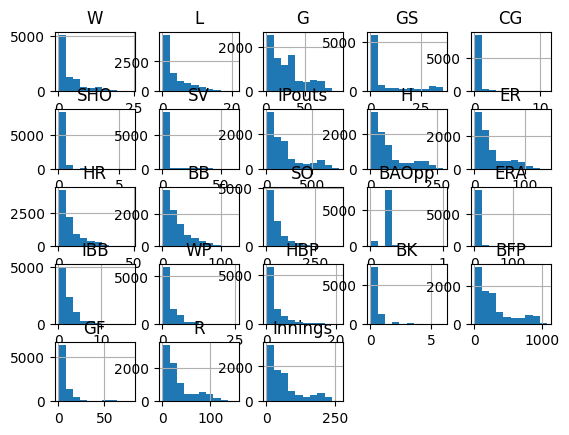

In [17]:
feat = ['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER',
       'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF',
       'R', 'Innings']
pitch[feat].hist()
plt.show()

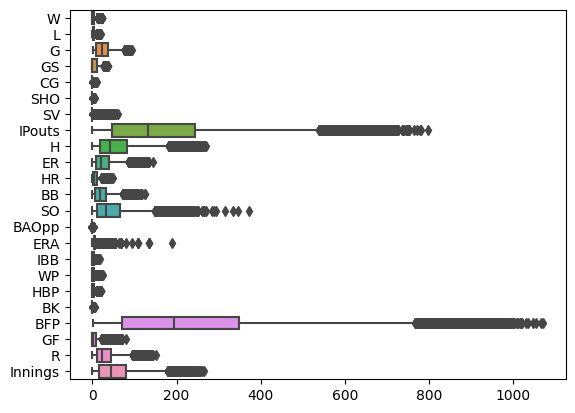

In [18]:
sns.boxplot(pitch[feat], orient='h')
plt.show()

It looks like we have some extremely skewed data (to be expected), and it seems all columns have many values which exceed the third quartile.

## Starters and Relievers

Now I would like to split the data into two broad categories of pitchers, starters and relievers.

In [19]:
pd.pivot_table(pitch, index=["yearID"], values=['Innings'], aggfunc=np.max, dropna=True, sort=True)

,Innings
yearID,
2000,251.000000
2001,256.666667
2002,260.000000
2003,266.000000
2004,255.000000
2005,246.333333
2006,240.666667
2007,241.000000
2008,246.000000


I will use Innings pitched as a metric, and although it's not a scientific method I will say >=150 innings = Starter, and beteween 70 and 100 innings = Reliever.

In [20]:
starter = pitch[pitch['Innings'] >= 150].copy()
reliever = pitch[pitch['Innings'] >= 70].copy()
reliever = reliever[reliever['Innings'] <= 100].copy()

Lets Look at these data over time

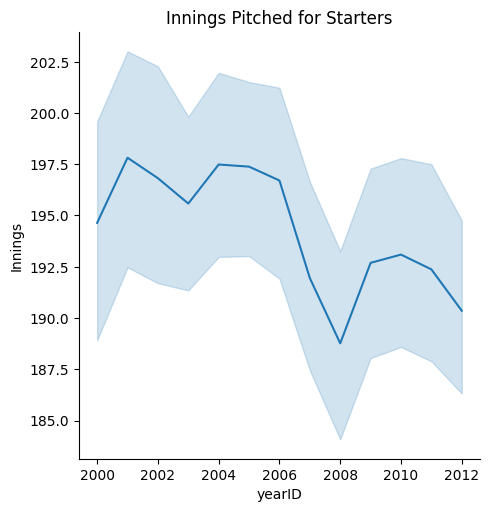

In [21]:
sns.relplot(data=starter, kind="line", x="yearID", y="Innings",  errorbar='ci')
plt.title('Innings Pitched for Starters')
warnings.filterwarnings("ignore")

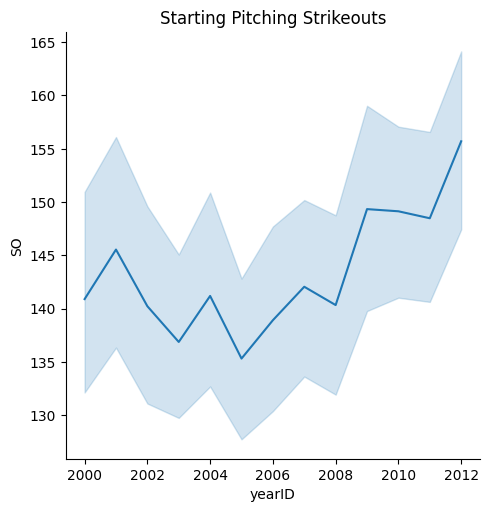

In [22]:
sns.relplot(data=starter, kind="line", x="yearID", y="SO", errorbar='ci')
plt.title("Starting Pitching Strikeouts")
warnings.filterwarnings("ignore")

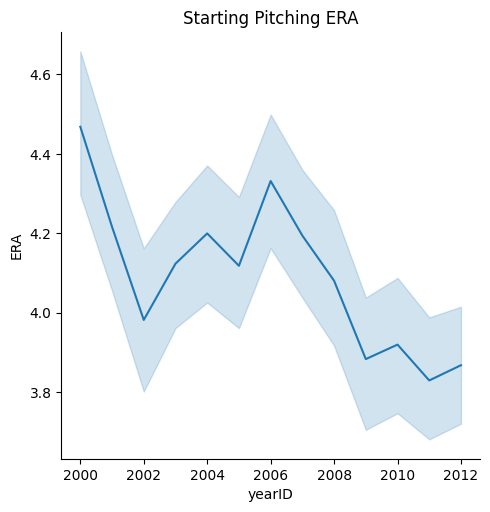

In [23]:
sns.relplot(data=starter, kind="line", x="yearID", y="ERA", errorbar='ci')
plt.title("Starting Pitching ERA")
warnings.filterwarnings("ignore")

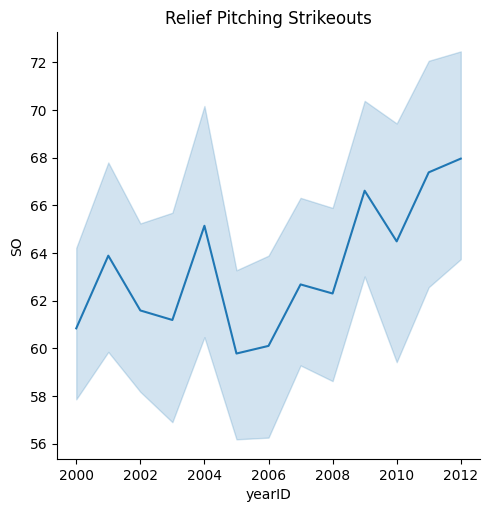

In [24]:
sns.relplot(data=reliever, kind="line", x="yearID", y="SO", errorbar='ci')
plt.title("Relief Pitching Strikeouts")
warnings.filterwarnings("ignore")

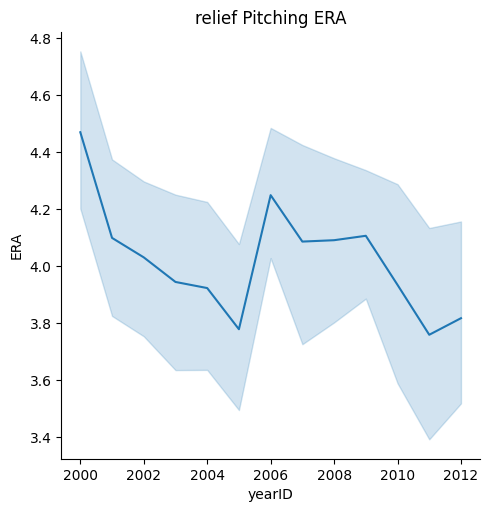

In [25]:
sns.relplot(data=reliever, kind="line", x="yearID", y="ERA", errorbar='ci')
plt.title("relief Pitching ERA")
warnings.filterwarnings("ignore")

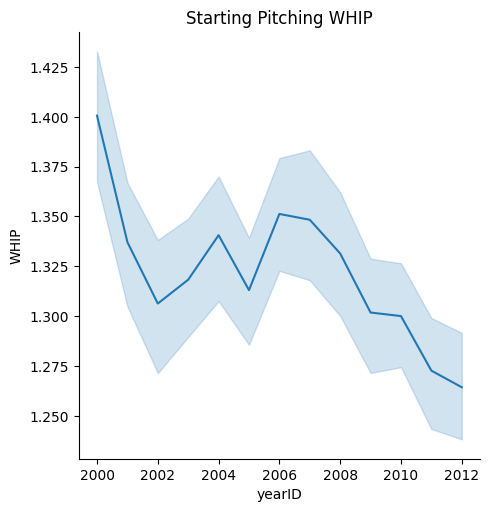

In [26]:
sns.relplot(data=starter, kind="line", x="yearID", y="WHIP", errorbar='ci')
plt.title("Starting Pitching WHIP")
warnings.filterwarnings("ignore")

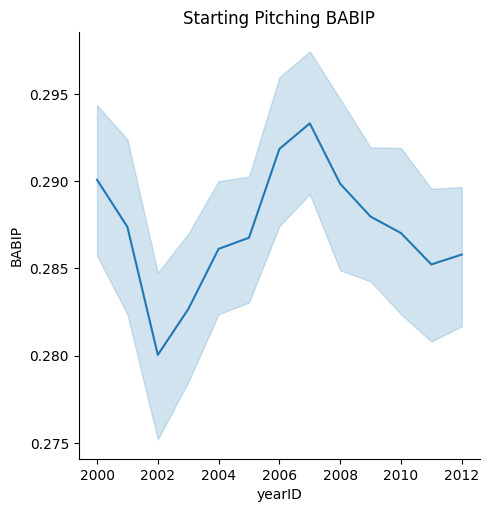

In [27]:
sns.relplot(data=starter, kind="line", x="yearID", y="BABIP", errorbar='ci')
plt.title("Starting Pitching BABIP")
warnings.filterwarnings("ignore")

In [28]:
pd.pivot_table(starter, index=["yearID"], values=['SO', 'ERA', 'WHIP', 'BABIP', 'IPouts', 'BBPer', 'kPer'], aggfunc=np.min, dropna=True, sort=True)

,BABIP,BBPer,ERA,IPouts,SO,WHIP,kPer
yearID,,,,,,,
2000,0.229339,0.088861,1.74,454,71,0.737327,0.088861
2001,0.238719,0.096529,2.49,452,80,1.009346,0.096529
2002,0.229446,0.088305,2.26,450,67,0.923077,0.088305
2003,0.233471,0.054632,2.22,457,46,0.953451,0.054632
2004,0.234615,0.066667,2.27,462,56,0.899593,0.066667
2005,0.238381,0.077713,1.87,468,53,0.949309,0.077713
2006,0.223629,0.084444,2.77,458,70,0.997147,0.084444
2007,0.236842,0.087393,2.54,450,61,1.061194,0.087393
2008,0.232236,0.094183,2.53,450,68,1.052846,0.094183


The trends are very clear. ERA, WHIP, and BABIP are going down for starters and relievers (less for releivers) while Strike Outs are going up. 

### Starter
Now to make a response for an ideal starter.

In [29]:
starter['response'] = np.where((starter['BABIP'] < 0.25), 1, 0).copy()
starter['response'] = np.where((starter['ERA'] < 2), 1, 0).copy()
starter['response'] = np.where((starter['WHIP'] < 1), 1, 0).copy()
starter['response'] = np.where((starter['SO'] > 220), 1, 0).copy()
len(starter[starter['response'].isin([1])]) / len(starter['response'])

0.039662447257383965

I will be attempting to locate a Starter with an ERA below 2, a WHIP below 1, and BABIP below 0.25, and with strike outs over 220. Furthermore, we are attempting to locate less than 4% of the data, which means the data is very unbalanced.

### Feature Correlation

Text(0.5, 1.0, 'HeatMap for Starter Correlation')

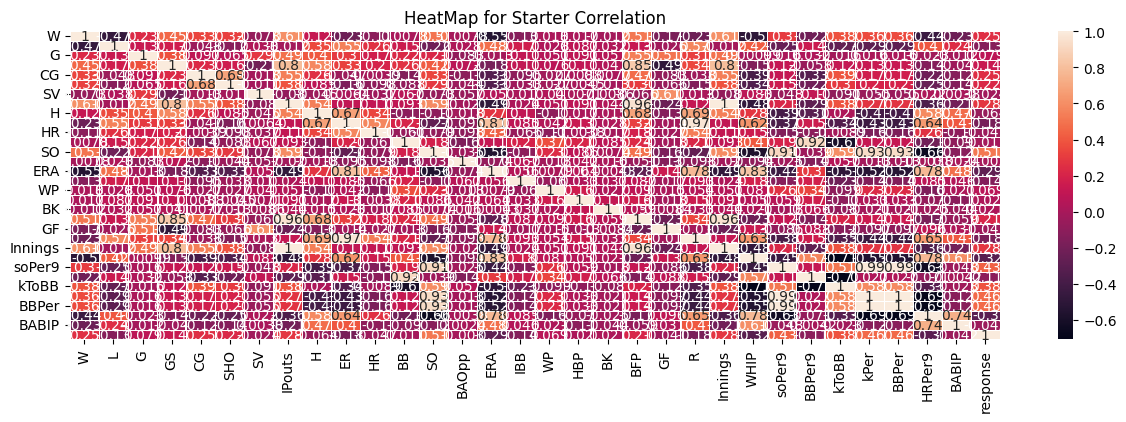

In [30]:
features = ['W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER',
       'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF',
       'R', 'Innings', 'WHIP', 'soPer9', 'BBPer9', 'kToBB', 'kPer', 'BBPer',
       'HRPer9', 'BABIP', 'response']
startCorr = starter[features].corr()
plt.figure(figsize=(15, 4))
sns.heatmap(startCorr, annot=True, linewidth=.5)
plt.title('HeatMap for Starter Correlation')

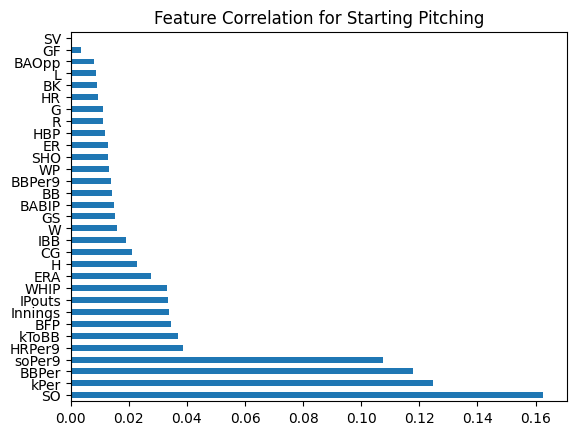

[SO         0.162604
 kPer       0.124569
 BBPer      0.117988
 soPer9     0.107387
 HRPer9     0.038546
 kToBB      0.036909
 BFP        0.034648
 Innings    0.033850
 IPouts     0.033553
 WHIP       0.033079
 ERA        0.027725
 H          0.022858
 CG         0.021226
 IBB        0.019122
 W          0.015907
 GS         0.015348
 BABIP      0.014788
 BB         0.014211
 BBPer9     0.013985
 WP         0.013133
 SHO        0.012937
 ER         0.012888
 HBP        0.011746
 R          0.011270
 G          0.011193
 HR         0.009292
 BK         0.008943
 L          0.008798
 BAOpp      0.007924
 GF         0.003571
 SV         0.000000
 dtype: float64]

In [31]:
X = starter[features].copy()
y = X.pop('response')
def extraTree(n):
    model = ExtraTreesClassifier()
    model.fit(X, y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.title('Feature Correlation for Starting Pitching')
    plt.show()
    feat = []
    feat.append(feat_importances.nlargest(n))
    #print(feat_importances.sort_values(ascending=False))
    return feat
extraTree(40)

Now I will put in the correlated features, scale and split the data.

In [37]:
updatedFeatures = ['SO', 'soPer9', 'BBPer', 'kPer', 'kToBB', 'IPouts', 'response', 'Innings', 'GS', 'WHIP', 'BFP', 'G', 'H', 'ERA', 'W', 'GS']
newFeat = ['SO', 'soPer9', 'BBPer', 'kPer']
X = starter[updatedFeatures].copy()
X1 = starter[newFeat]
y = X.pop('response')
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X2 = scaler.fit_transform(X1)
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)

I will use a Gaussian Niave Bayes model

In [38]:
nb = GaussianNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F_Measure = f1_score(y_test, y_pred)

accuracy: 0.9324894514767933, recall: 1.0, precision: 0.2727272727272727, F-score: 0.42857142857142855


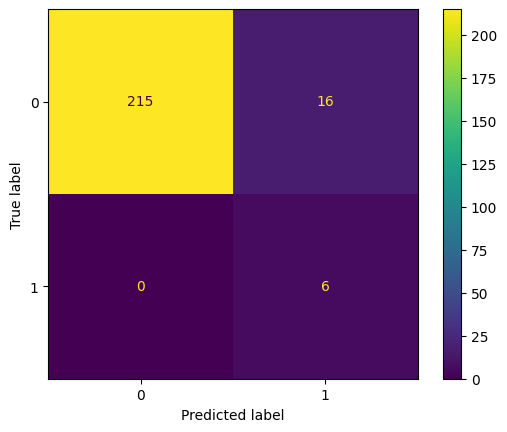

In [39]:
cm = confusion_matrix(y_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}, F-score: {F_Measure}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

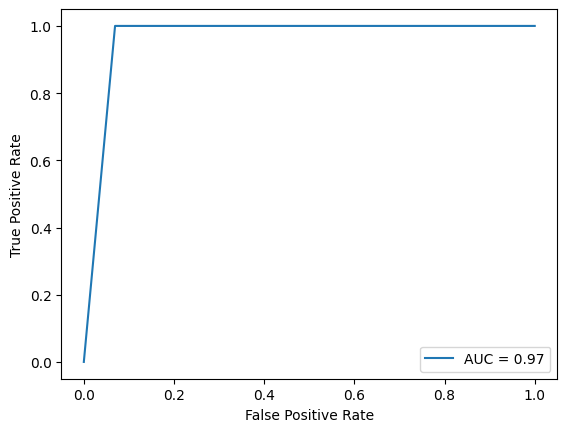

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

It's very tempting to say wow 93% accuracy we have a great model!, but it's very important to remember that if the model simply predicted 0s for everything it would be a very accurate model. We should always have plenty of way to gauge model performance, each one can provide valuable insight, our F Measure is very low, and judging from our Confusion Matrix we can see the model did not perform very well, we have a True Positive Rate of 6/22. It is clear that we will need to account for the unbalanced nature of these data.

In [41]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X1, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=1)

In [42]:
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F_Measure = f1_score(y_test, y_pred)

accuracy: 0.9605263157894737, recall: 1.0, precision: 0.9246861924686193, F-score: 0.9608695652173914


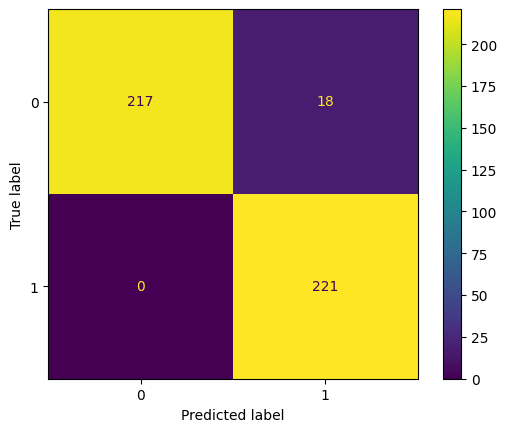

In [43]:
cm = confusion_matrix(y_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}, F-score: {F_Measure}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Utilizing the oversampler for unbalanced data has improved the performance of this model tremendously, We have an F Measure and Precision over 90%

### Relievers

In [44]:
reliever['response'] = np.where((reliever['BABIP'] < 0.2), 1, 0).copy()
reliever['response'] = np.where((reliever['ERA'] < .001), 1, 0).copy()
reliever['response'] = np.where((reliever['WHIP'] < .001), 1, 0).copy()
reliever['response'] = np.where((reliever['SO'] > 70), 1, 0).copy()
len(reliever[reliever['response'].isin([1])]) / len(reliever['response'])

0.3066132264529058

What I would like to do is locate a reliever with a BABIP under 0.2, a very low ERA and WHIP and over 70 strikouts.

### Feature Correlation

Text(0.5, 1.0, 'HeatMap for Reliever Correlation')

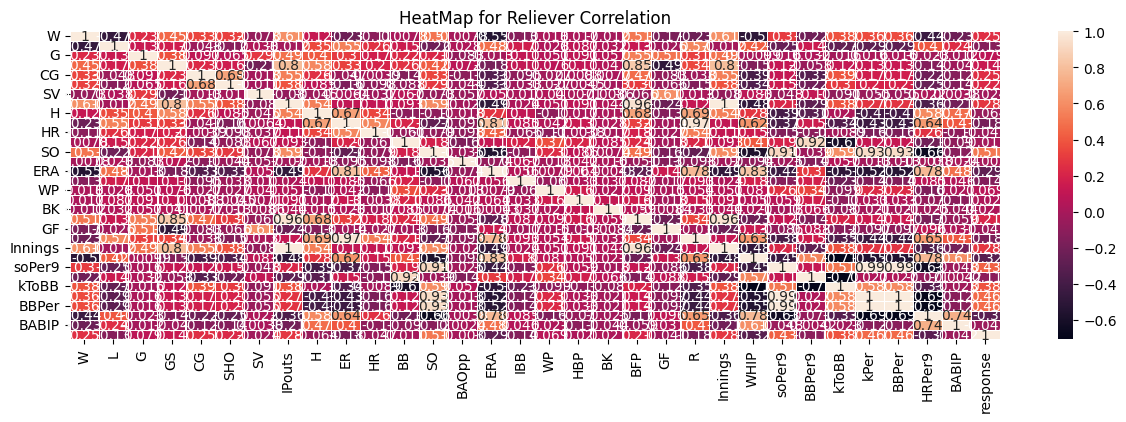

In [46]:
reliefCorr = reliever[features].corr()
plt.figure(figsize=(15, 4))
sns.heatmap(startCorr, annot=True, linewidth=.5)
plt.title('HeatMap for Reliever Correlation')

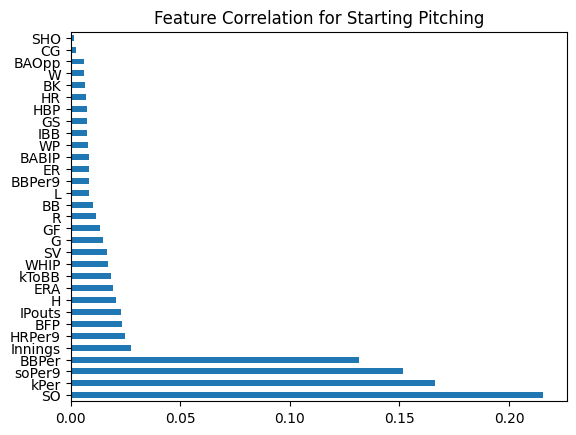

[SO         0.215561
 kPer       0.166217
 soPer9     0.151840
 BBPer      0.131494
 Innings    0.027654
 HRPer9     0.024813
 BFP        0.023516
 IPouts     0.022959
 H          0.020744
 ERA        0.019377
 kToBB      0.018564
 WHIP       0.017030
 SV         0.016558
 G          0.014633
 GF         0.013460
 R          0.011484
 BB         0.010138
 L          0.008493
 BBPer9     0.008477
 ER         0.008432
 BABIP      0.008220
 WP         0.008024
 IBB        0.007612
 GS         0.007414
 HBP        0.007319
 HR         0.007090
 BK         0.006703
 W          0.006245
 BAOpp      0.005905
 CG         0.002502
 SHO        0.001521
 dtype: float64]

In [47]:
X = reliever[features].copy()
y = X.pop('response')
def extraTree(n):
    model = ExtraTreesClassifier()
    model.fit(X, y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.title('Feature Correlation for Starting Pitching')
    plt.show()
    feat = []
    feat.append(feat_importances.nlargest(n))
    #print(feat_importances.sort_values(ascending=False))
    return feat
extraTree(40)

We can see Strike Outs, Strike Out Percentage, Strike Outs per 9 Innings, and Walk Percentage are the top correlated features, we can verify this with the Heat Map as well but the advatage being we can see if it is a positive or a negative correlation.

Now I will update the features, scale, and split.

In [48]:
updatedFeatures = ['SO', 'soPer9', 'kPer', 'BBPer', 'HRPer9', 'H', 'IPouts', 'BFP', 'kToBB', 'ERA', 'WHIP', 'response']
X = reliever[updatedFeatures].copy()
y = X.pop('response')
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=1)

I will use a Gaussian Naive Bayes Model

In [50]:
nb = GaussianNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
F_Measure = f1_score(y_test, y_pred)

accuracy: 0.895, recall: 0.8787878787878788, precision: 0.8169014084507042, F-score: 0.8467153284671534


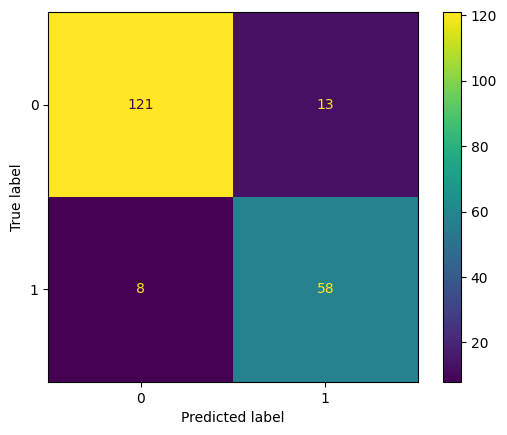

In [51]:
cm = confusion_matrix(y_test, y_pred)
print(f"accuracy: {accuracy}, recall: {recall}, precision: {precision}, F-score: {F_Measure}")
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [52]:
f"True Positive Rate: {round(58/(58+13),2)}%"

'True Positive Rate: 0.82%'

It seems we are able to predict a top tier releiver far more accurately than we were a top tier starter, and can check this in the same manner as our starters.

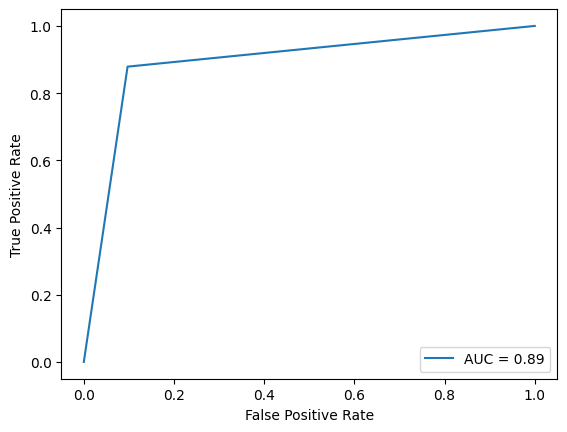

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()